## Imports

In [6]:
# !pip install pydicom matplotlib
# !pip install opencv-python-headless numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 19.7 MB/s eta 0:00:0000:0100:01


Processing folder: SCD0002001


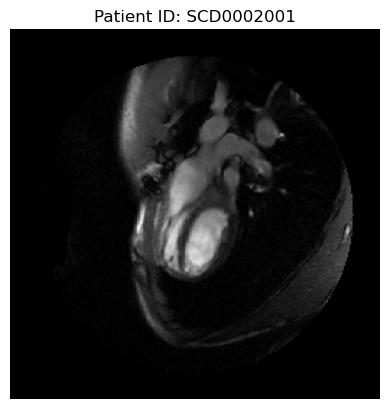

Processing folder: SCD0002101


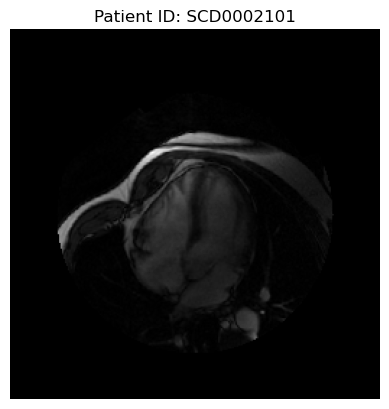

Processing folder: SCD0002201


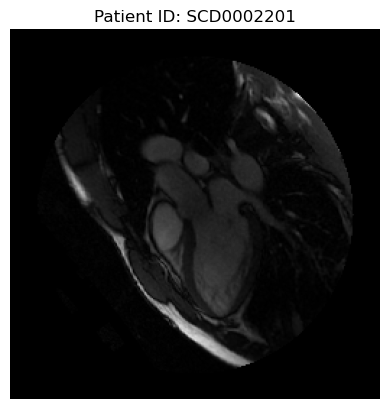

Processing folder: SCD0002301


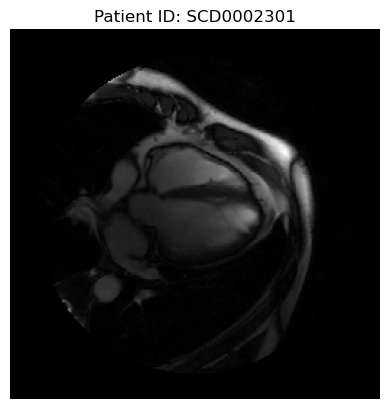

Processing folder: SCD0002401


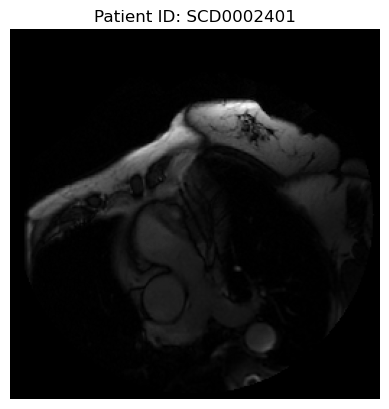

Processing folder: SCD0002501


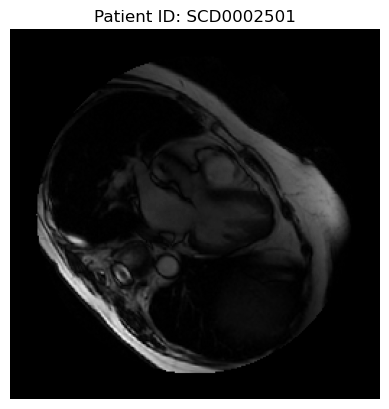

Processing folder: SCD0002601


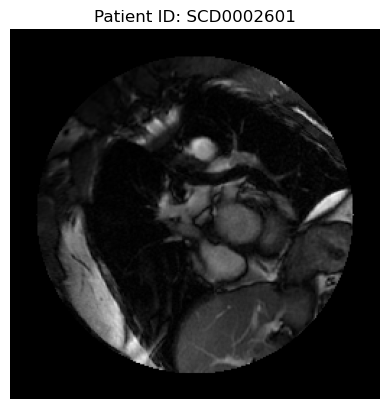

Processing folder: SCD0002701


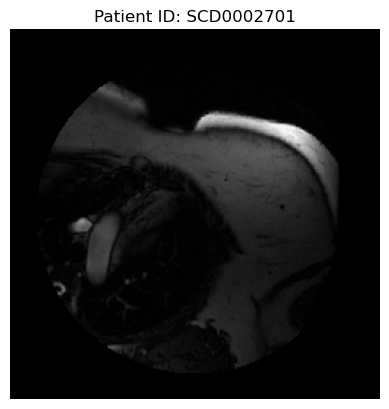

Processing folder: SCD0002801


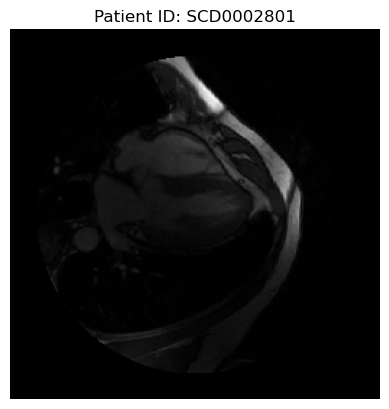

Processing folder: SCD0002901


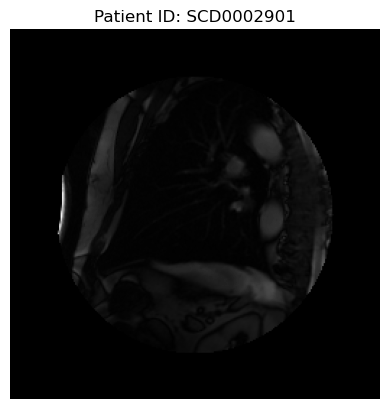

In [1]:
import os
import pydicom
import matplotlib.pyplot as plt

def load_dicom_files(directory):
    """Loads all DICOM files from a specified directory."""
    dicom_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".dcm"):
                dicom_files.append(os.path.join(root, file))
    return dicom_files

def display_dicom_image(dicom_file_path):
    """Displays a DICOM image using matplotlib."""
    ds = pydicom.dcmread(dicom_file_path)
    pixel_array = ds.pixel_array  # Extract image data
    plt.imshow(pixel_array, cmap="gray")
    plt.title(f"Patient ID: {ds.PatientID}")
    plt.axis("off")
    plt.show()


# Path to the parent directory containing subdirectories with DICOM files
#parent_dir = "/Volumes/sci_final/AMRGAtlas"
#parent_dir = "/Volumes/sci_final/SCD_IMAGES_02"
parent_dir = "/Volumes/sci_final/SCD_IMAGES_03"

for subfolder in os.listdir(parent_dir):
    subfolder_path = os.path.join(parent_dir, subfolder)
    if os.path.isdir(subfolder_path):
        print(f"Processing folder: {subfolder}")
        dicom_files = load_dicom_files(subfolder_path)
        if dicom_files:
            display_dicom_image(dicom_files[0])


## Open and read DICOM files

In [3]:
import os
import pydicom
import numpy as np
import cv2
from PIL import Image

# Fine-tuned parameters for Shi-Tomasi
SHI_TOMASI_PARAMS = {
    "maxCorners": 150,      # Maximum number of corners
    "qualityLevel": 0.03,   # Minimum accepted quality of corners
    "minDistance": 7        # Minimum distance between detected corners
}

# Fine-tuned parameters for Lucas-Kanade
LUCAS_KANADE_PARAMS = {
    "winSize": (15, 15),    # Size of the window for optical flow
    "maxLevel": 3,          # Number of pyramid levels
    "criteria": (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)  # Termination criteria
}

def load_dicom_files(directory):
    """Loads valid DICOM files from a specified directory, skipping hidden files."""
    dicom_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".dcm") and not file.startswith("._"):  # Skip hidden macOS files
                dicom_files.append(os.path.join(root, file))
    return sorted(dicom_files)  # Sort files for sequential processing

def preprocess_dicom(dicom_file_path, fixed_size=(256, 256)):
    """Preprocesses DICOM files to ensure consistent dimensions and contrast."""
    try:
        ds = pydicom.dcmread(dicom_file_path, force=True)
        if not hasattr(ds, "pixel_array"):
            print(f"No pixel array found in {dicom_file_path}. Skipping this file.")
            return None
        pixel_array = ds.pixel_array
        pixel_array = cv2.normalize(pixel_array, None, 0, 255, cv2.NORM_MINMAX).astype("uint8")
        img_eq = cv2.equalizeHist(pixel_array)
        img_resized = cv2.resize(img_eq, fixed_size)
        return img_resized
    except Exception as e:
        print(f"Error reading {dicom_file_path}: {e}")
        return None

# Feature detection function
def detect_features(image):
    """Detects Shi-Tomasi corners in the image."""
    corners = cv2.goodFeaturesToTrack(image, **SHI_TOMASI_PARAMS)
    return np.float32([f.ravel() for f in corners]) if corners is not None else []

# Optical flow computation
def compute_optical_flow(prev_img, next_img, features):
    """Computes Lucas-Kanade optical flow."""
    next_pts, status, _ = cv2.calcOpticalFlowPyrLK(prev_img, next_img, features, None, **LUCAS_KANADE_PARAMS)
    return next_pts, status


def overlay_optical_flow(image, features, flow_vectors):
    """Creates a frame with optical flow vectors overlaid."""
    image_copy = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)
    for (x1, y1), (x2, y2) in zip(features, flow_vectors):
        pt1 = (int(x1), int(y1))
        pt2 = (int(x2), int(y2))
        cv2.arrowedLine(image_copy, pt1, pt2, color=(0, 255, 0), thickness=1)
    return cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

def save_results_as_gif(frames, output_path, duration=500):
    """Saves a list of frames as an animated GIF."""
    pil_images = [Image.fromarray(frame) for frame in frames]
    pil_images[0].save(
        output_path,
        save_all=True,
        append_images=pil_images[1:],
        duration=duration,
        loop=0
    )
    print(f"GIF saved at {output_path}")

def process_dataset(dataset_dir, output_dir):
    """Processes all datasets in the directory and saves separate GIFs for each subfolder."""
    for folder in os.listdir(dataset_dir):
        folder_path = os.path.join(dataset_dir, folder)
        if os.path.isdir(folder_path):
            print(f"Processing folder: {folder}")
            dicom_files = load_dicom_files(folder_path)
            if len(dicom_files) < 2:
                print(f"Not enough frames in {folder} to compute optical flow.")
                continue
            
            # Preprocess frames
            images = [preprocess_dicom(dcm) for dcm in dicom_files]
            images = [img for img in images if img is not None]
            if len(images) < 2:
                print(f"Not enough valid frames in {folder} after preprocessing.")
                continue
            
            # Compute optical flow and generate frames
            frames = []
            for i in range(len(images) - 1):
                prev_img = images[i]
                next_img = images[i + 1]
                features = detect_features(prev_img)
                if len(features) == 0:
                    print(f"No features detected in frame {i}. Skipping optical flow computation.")
                    continue
                
                next_pts, status = compute_optical_flow(prev_img, next_img, features)
                good_prev_pts = features[status.flatten() == 1]
                good_next_pts = next_pts[status.flatten() == 1]
                
                # Overlay optical flow vectors
                frame = overlay_optical_flow(next_img, good_prev_pts, good_next_pts)
                frames.append(frame)

            # Create subfolder-specific output directory
            folder_output_dir = os.path.join(output_dir, folder)
            if not os.path.exists(folder_output_dir):
                os.makedirs(folder_output_dir)

            # Save GIF in the folder's output directory
            gif_path = os.path.join(folder_output_dir, f"{folder}.gif")
            if frames:
                save_results_as_gif(frames, gif_path)


# AMRGAtlas
# SCD_IMAGES_01
# SCD_IMAGES_02

#output_directory = "./final/AMRGAtlas"    # Replace with the desired output directory
output_directory = "./final/SCD_IMAGES_03"
process_dataset(parent_dir, output_directory)


Processing folder: SCD0002001
GIF saved at ./final/SCD_IMAGES_03/SCD0002001/SCD0002001.gif
Processing folder: SCD0002101
GIF saved at ./final/SCD_IMAGES_03/SCD0002101/SCD0002101.gif
Processing folder: SCD0002201
GIF saved at ./final/SCD_IMAGES_03/SCD0002201/SCD0002201.gif
Processing folder: SCD0002301
GIF saved at ./final/SCD_IMAGES_03/SCD0002301/SCD0002301.gif
Processing folder: SCD0002401
GIF saved at ./final/SCD_IMAGES_03/SCD0002401/SCD0002401.gif
Processing folder: SCD0002501
GIF saved at ./final/SCD_IMAGES_03/SCD0002501/SCD0002501.gif
Processing folder: SCD0002601
GIF saved at ./final/SCD_IMAGES_03/SCD0002601/SCD0002601.gif
Processing folder: SCD0002701
GIF saved at ./final/SCD_IMAGES_03/SCD0002701/SCD0002701.gif
Processing folder: SCD0002801
GIF saved at ./final/SCD_IMAGES_03/SCD0002801/SCD0002801.gif
Processing folder: SCD0002901
GIF saved at ./final/SCD_IMAGES_03/SCD0002901/SCD0002901.gif
